# **Set-up**

Terminal command:

```console
pip install numpy
pip install pandas
pip install openpyxl
pip install datetime
pip install matplotlib
```

Import packages needed for notebook:

In [107]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

Ensure current working directory is in "EC1B1" folder

# **Read Excel**

In [108]:
df_spain_raw = pd.read_excel('./data/data_spain.xlsx')
df_us_raw = pd.read_excel('./data/data_united_states.xlsx')

We save dataframe in another variable to keep the raw data untouched

In [109]:
spain_1 = df_spain_raw
us_1 = df_us_raw

Inspect the dataframe

In [110]:
spain_1.head()

,International Financial Statistics (IFS),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,"Economic Activity, Industrial Production, Index","Exchange Rates, US Dollar per Domestic Currenc...","International Reserves and Liquidity, Reserves...","Prices, Consumer Price Index, All items, Index"
1,Jan 1960,NaN,0.016667,233,2.857368
2,Feb 1960,NaN,0.016667,253,2.855049
3,Mar 1960,NaN,0.016667,299,2.851573
4,Apr 1960,NaN,0.016667,326,2.853891


# **Initial Cleaning**

## For Spain:

In [111]:
spain_2 = spain_1 \
    .rename(columns={'International Financial Statistics (IFS)': 'date', 'Unnamed: 1': 'spain_industrial_index', 'Unnamed: 2': 'spain_nominal_exchange_rate', 'Unnamed: 3': 'spain_reserves', 'Unnamed: 4': 'spain_price_index'}) [1:]

In [112]:
spain_3 = spain_2
spain_3['spain_nominal_exchange_rate'] = spain_3['spain_nominal_exchange_rate'].apply(lambda x: 1/x)

In [113]:
spain_4 = spain_3
spain_4['date'] = spain_4['date'].apply(lambda x: datetime.strptime(x, '%b %Y'))

In [114]:
spain_5 = spain_4
spain_columns = ['spain_industrial_index', 'spain_nominal_exchange_rate', 'spain_reserves', 'spain_price_index']
for column in spain_columns:
    spain_5[column] = pd.to_numeric(spain_5[column])
    spain_5[column] = spain_5[column].round(2)

In [115]:
spain_5.head()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index
1,1960-01-01,NaN,60.0,233.0,2.86
2,1960-02-01,NaN,60.0,253.0,2.86
3,1960-03-01,NaN,60.0,299.0,2.85
4,1960-04-01,NaN,60.0,326.0,2.85
5,1960-05-01,NaN,60.0,360.0,2.85


In [116]:
spain_basic_cleaned = spain_5

## Using similar codes, repeat for US:

In [117]:
# Repeat first step using code from Spain
us_1 = us_1 \
    .rename(columns={'International Financial Statistics (IFS)': 'date', 'Unnamed: 1': 'us_reserves', 'Unnamed: 2': 'us_price_index'}) [1:]

# Tidy the data using similar process
us_1['date'] = us_1['date'].apply(lambda x: datetime.strptime(x, '%b %Y'))

for column in ['us_reserves', 'us_price_index']:
    us_1[column] = pd.to_numeric(us_1[column])
    us_1[column] = us_1[column].round(2)

us_basic_cleaned = us_1

In [118]:
us_basic_cleaned.head()

,date,us_reserves,us_price_index
1,1960-01-01,21478.1,13.44
2,1960-02-01,21395.7,13.48
3,1960-03-01,21344.7,13.48
4,1960-04-01,21278.0,13.53
5,1960-05-01,21234.3,13.53


# **Data manipulation**

Define real exchange rate

In [119]:
merged_1 = pd.merge(spain_basic_cleaned, us_basic_cleaned, on = 'date')

In [120]:
merged_1.head()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index
0,1960-01-01,NaN,60.0,233.0,2.86,21478.1,13.44
1,1960-02-01,NaN,60.0,253.0,2.86,21395.7,13.48
2,1960-03-01,NaN,60.0,299.0,2.85,21344.7,13.48
3,1960-04-01,NaN,60.0,326.0,2.85,21278.0,13.53
4,1960-05-01,NaN,60.0,360.0,2.85,21234.3,13.53


Create the lag variables:

In [121]:
# For Spain
merged_1['spain_nominal_exchange_rate_lag_1'] = merged_1['spain_nominal_exchange_rate'].shift(1)
merged_1['spain_price_index_lag_1'] = merged_1['spain_price_index'].shift(1)
merged_1['spain_industrial_index_lag_1'] = merged_1['spain_industrial_index'].shift(1)
merged_1['spain_industrial_index_lag_12'] = merged_1['spain_industrial_index'].shift(12)

# For US
merged_1['us_price_index_lag_1'] = merged_1['us_price_index'].shift(1)

# Save as new dataframe
merged_2 = merged_1

In [122]:
merged_2.head()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,spain_industrial_index_lag_12,us_price_index_lag_1
0,1960-01-01,NaN,60.0,233.0,2.86,21478.1,13.44,NaN,NaN,NaN,NaN,NaN
1,1960-02-01,NaN,60.0,253.0,2.86,21395.7,13.48,60.0,2.86,NaN,NaN,13.44
2,1960-03-01,NaN,60.0,299.0,2.85,21344.7,13.48,60.0,2.86,NaN,NaN,13.48
3,1960-04-01,NaN,60.0,326.0,2.85,21278.0,13.53,60.0,2.85,NaN,NaN,13.48
4,1960-05-01,NaN,60.0,360.0,2.85,21234.3,13.53,60.0,2.85,NaN,NaN,13.53


In [123]:
merged_2['spain_nominal_exchange_rate_growth'] = (merged_2['spain_nominal_exchange_rate'] - merged_2['spain_nominal_exchange_rate_lag_1']) / merged_2['spain_nominal_exchange_rate_lag_1'] * 100
merged_2['spain_real_exchange_rate'] = merged_2['spain_nominal_exchange_rate'] * merged_2['us_price_index'] / merged_2['spain_price_index']
merged_2['spain_real_exchange_rate_lag_1'] = merged_2['spain_real_exchange_rate'].shift(1)
merged_2['spain_real_exchange_rate_growth'] = (merged_2['spain_real_exchange_rate'] - merged_2['spain_real_exchange_rate_lag_1']) / merged_2['spain_real_exchange_rate_lag_1'] * 100
merged_2['spain_inflation_rate'] = (merged_2['spain_price_index'] - merged_2['spain_price_index_lag_1']) / merged_2['spain_price_index_lag_1'] * 100
merged_2['spain_industrial_growth'] = (merged_2['spain_industrial_index'] - merged_2['spain_industrial_index_lag_1']) / merged_2['spain_industrial_index_lag_1'] * 100
merged_2['spain_industrial_yearly_growth'] = (merged_2['spain_industrial_index'] - merged_2['spain_industrial_index_lag_12']) / merged_2['spain_industrial_index_lag_12'] * 100
merged_2['us_inflation_rate'] = (merged_2['us_price_index'] - merged_2['us_price_index_lag_1']) / merged_2['us_price_index_lag_1'] * 100
merged_3 = merged_2
merged_3.head()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,spain_industrial_index_lag_12,us_price_index_lag_1,spain_nominal_exchange_rate_growth,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate
0,1960-01-01,NaN,60.0,233.0,2.86,21478.1,13.44,NaN,NaN,NaN,NaN,NaN,NaN,281.958042,NaN,NaN,NaN,NaN,NaN,NaN
1,1960-02-01,NaN,60.0,253.0,2.86,21395.7,13.48,60.0,2.86,NaN,NaN,13.44,0.0,282.797203,281.958042,0.297619,0.00000,NaN,NaN,0.297619
2,1960-03-01,NaN,60.0,299.0,2.85,21344.7,13.48,60.0,2.86,NaN,NaN,13.48,0.0,283.789474,282.797203,0.350877,-0.34965,NaN,NaN,0.000000
3,1960-04-01,NaN,60.0,326.0,2.85,21278.0,13.53,60.0,2.85,NaN,NaN,13.48,0.0,284.842105,283.789474,0.370920,0.00000,NaN,NaN,0.370920
4,1960-05-01,NaN,60.0,360.0,2.85,21234.3,13.53,60.0,2.85,NaN,NaN,13.53,0.0,284.842105,284.842105,0.000000,0.00000,NaN,NaN,0.000000


In [124]:
spain_index_list = []
us_index_list = []
spain_first_value = merged_3.loc[0, 'spain_reserves']
us_first_value = merged_3.loc[0, 'us_reserves']

for value in merged_3['spain_reserves']:
    if value != None:
        index = value / spain_first_value * 100
    else:
        index = None

    spain_index_list.append(index)

for value in merged_3['us_reserves']:
    if value != None:
        index = value / us_first_value * 100
    else:
        index = None

    us_index_list.append(index)

merged_3['spain_reserves_index_1960'] = spain_index_list
merged_3['us_reserves_index_1960'] = us_index_list
merged_3 = merged_3.round(2)
merged_4 = merged_3
merged_4.head()

,date,spain_industrial_index,spain_nominal_exchange_rate,spain_reserves,spain_price_index,us_reserves,us_price_index,spain_nominal_exchange_rate_lag_1,spain_price_index_lag_1,spain_industrial_index_lag_1,...,spain_nominal_exchange_rate_growth,spain_real_exchange_rate,spain_real_exchange_rate_lag_1,spain_real_exchange_rate_growth,spain_inflation_rate,spain_industrial_growth,spain_industrial_yearly_growth,us_inflation_rate,spain_reserves_index_1960,us_reserves_index_1960
0,1960-01-01,NaN,60.0,233.0,2.86,21478.1,13.44,NaN,NaN,NaN,...,NaN,281.96,NaN,NaN,NaN,NaN,NaN,NaN,100.00,100.00
1,1960-02-01,NaN,60.0,253.0,2.86,21395.7,13.48,60.0,2.86,NaN,...,0.0,282.80,281.96,0.30,0.00,NaN,NaN,0.30,108.58,99.62
2,1960-03-01,NaN,60.0,299.0,2.85,21344.7,13.48,60.0,2.86,NaN,...,0.0,283.79,282.80,0.35,-0.35,NaN,NaN,0.00,128.33,99.38
3,1960-04-01,NaN,60.0,326.0,2.85,21278.0,13.53,60.0,2.85,NaN,...,0.0,284.84,283.79,0.37,0.00,NaN,NaN,0.37,139.91,99.07
4,1960-05-01,NaN,60.0,360.0,2.85,21234.3,13.53,60.0,2.85,NaN,...,0.0,284.84,284.84,0.00,0.00,NaN,NaN,0.00,154.51,98.86


In [125]:
df = merged_4

In [136]:
df.columns

Index(['date', 'spain_industrial_index', 'spain_nominal_exchange_rate',
       'spain_reserves', 'spain_price_index', 'us_reserves', 'us_price_index',
       'spain_nominal_exchange_rate_lag_1', 'spain_price_index_lag_1',
       'spain_industrial_index_lag_1', 'spain_industrial_index_lag_12',
       'us_price_index_lag_1', 'spain_nominal_exchange_rate_growth',
       'spain_real_exchange_rate', 'spain_real_exchange_rate_lag_1',
       'spain_real_exchange_rate_growth', 'spain_inflation_rate',
       'spain_industrial_growth', 'spain_industrial_yearly_growth',
       'us_inflation_rate', 'spain_reserves_index_1960',
       'us_reserves_index_1960'],
      dtype='object')

Code used to figure out outliers

```python
for item in df.columns[1:]:
    plt.figure()
    plt.hist(df[item])
    plt.title(str(item))
```

/var/folders/n2/rv87rvcx08s9hsq8cmkrj79h0000gn/T/ipykernel_61236/1987101995.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


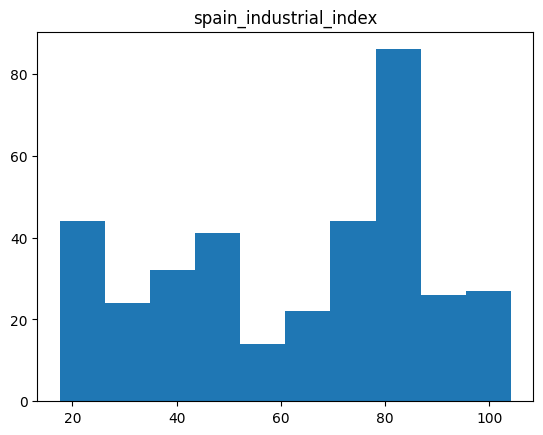

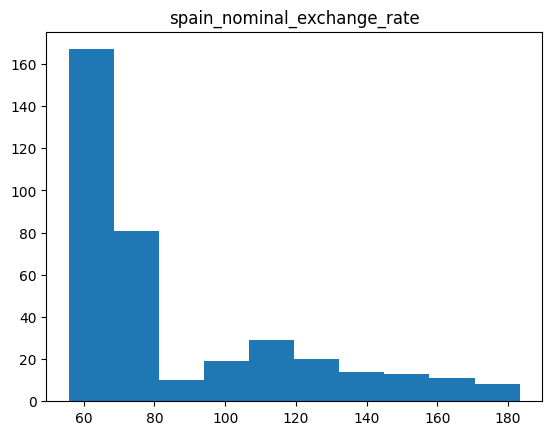

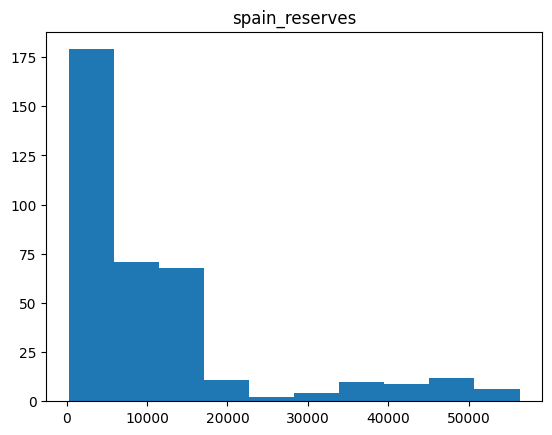

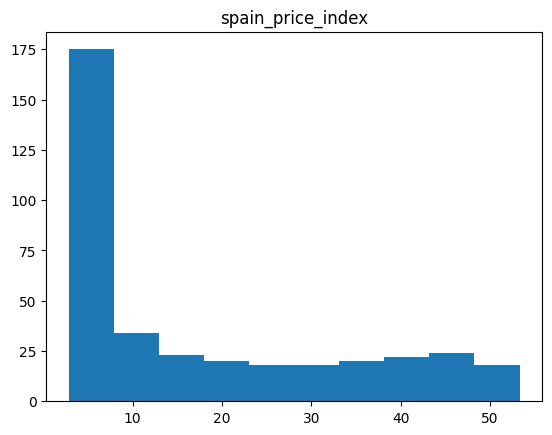

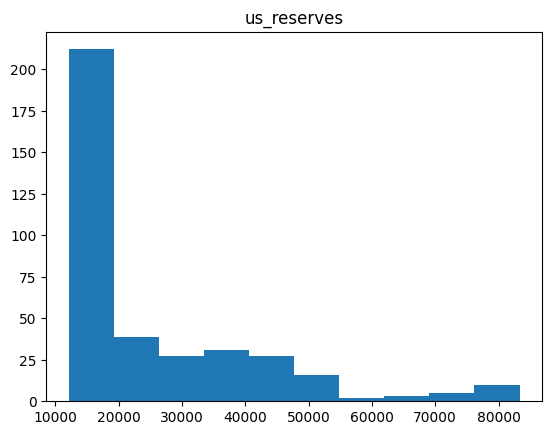

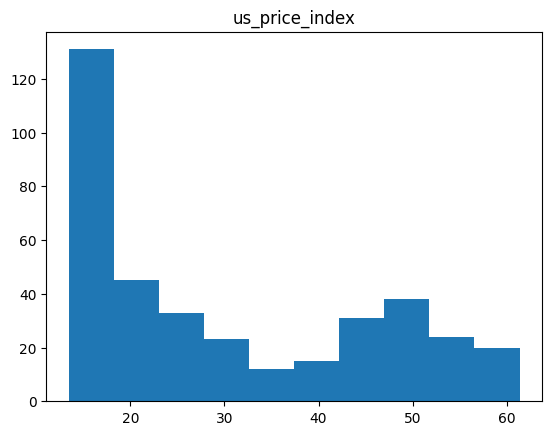

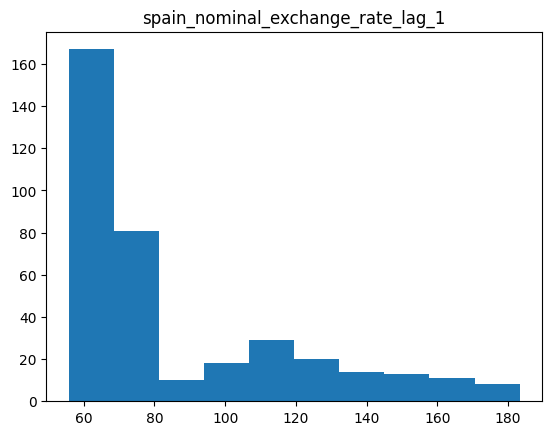

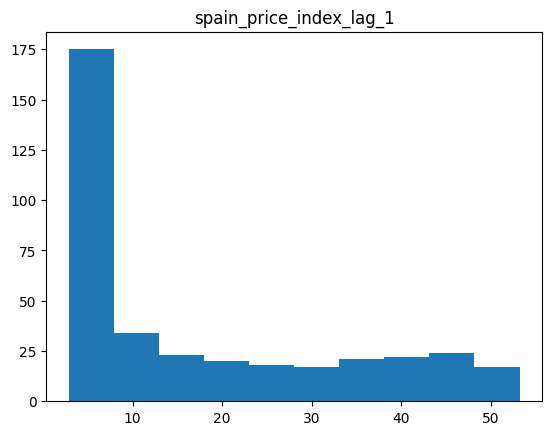

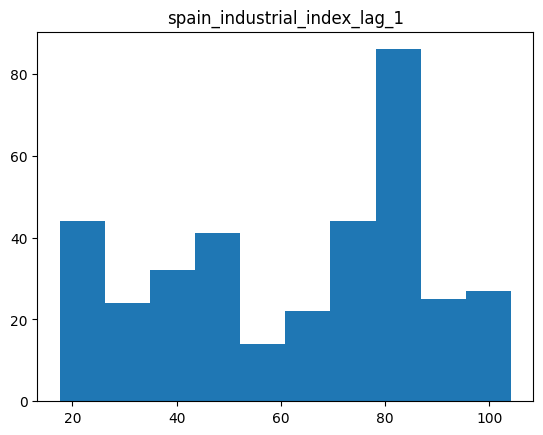

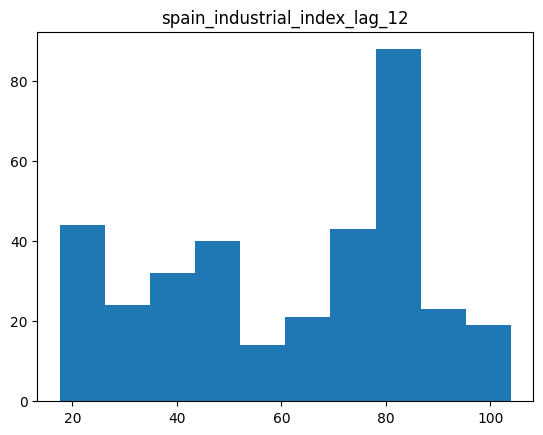

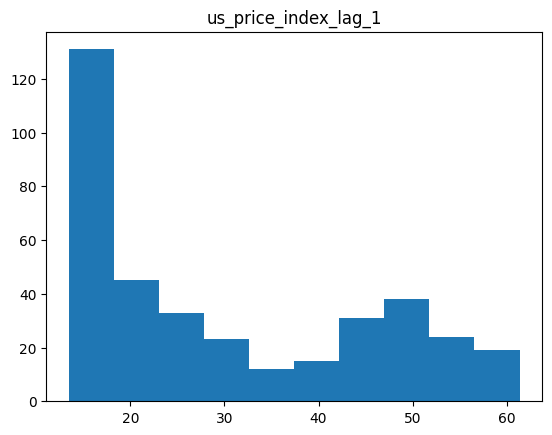

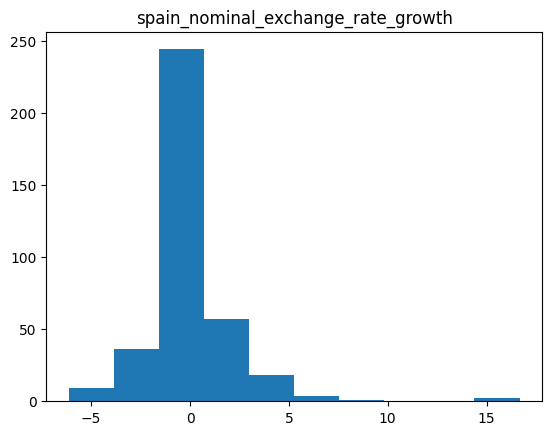

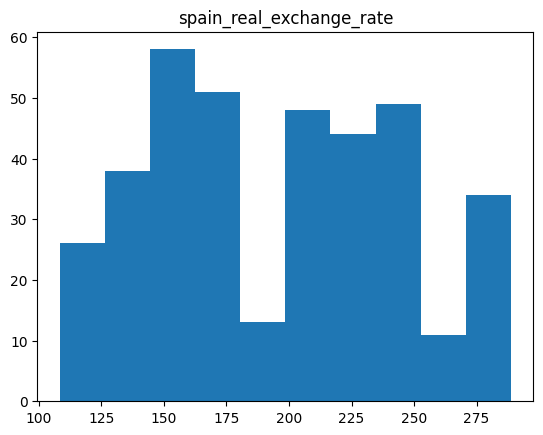

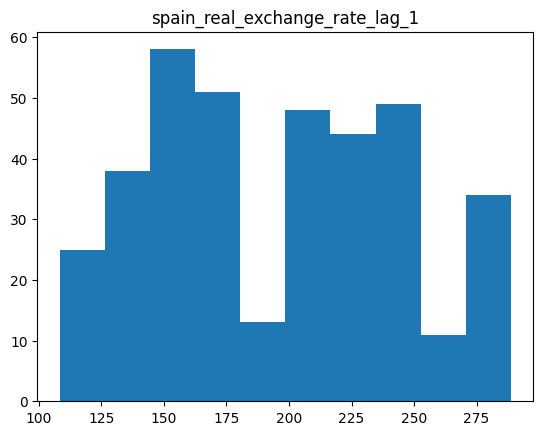

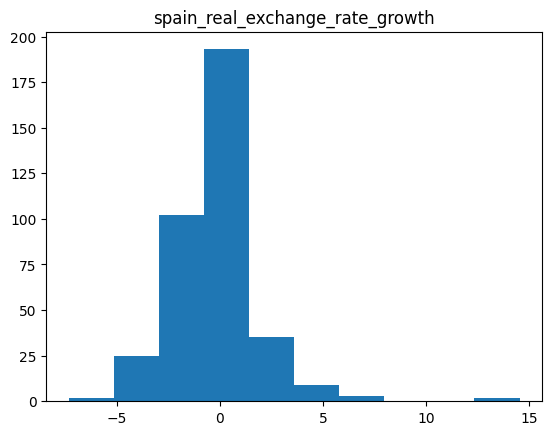

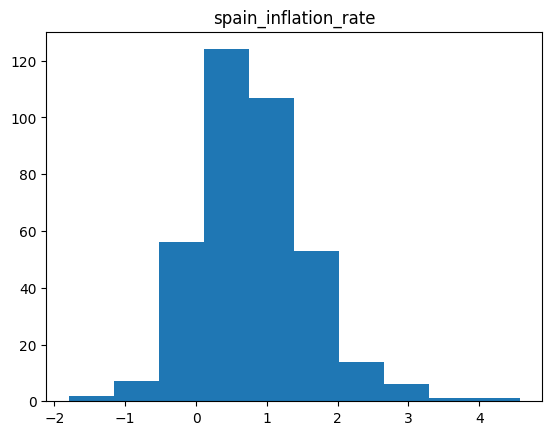

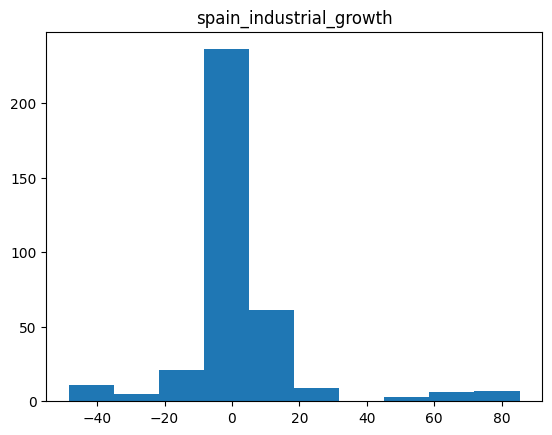

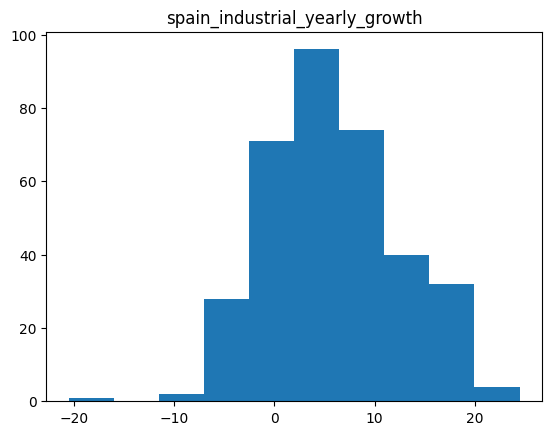

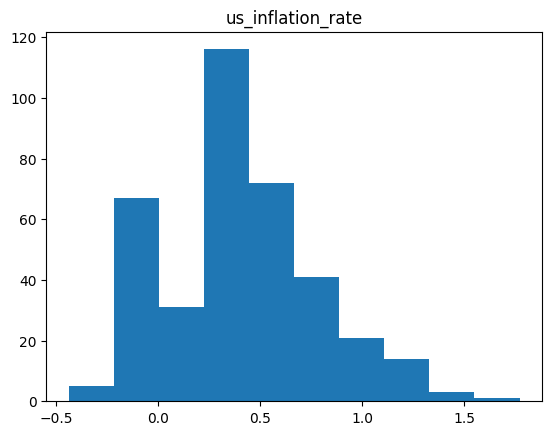

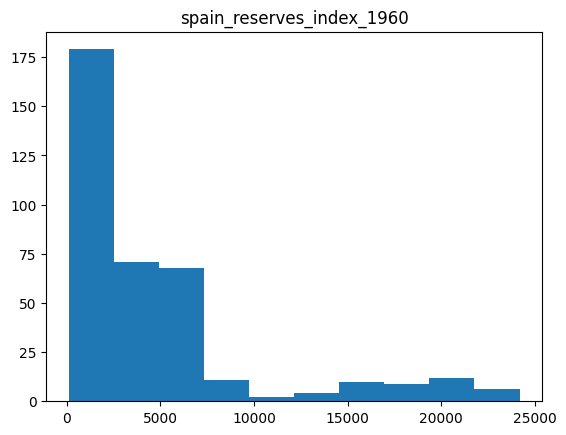

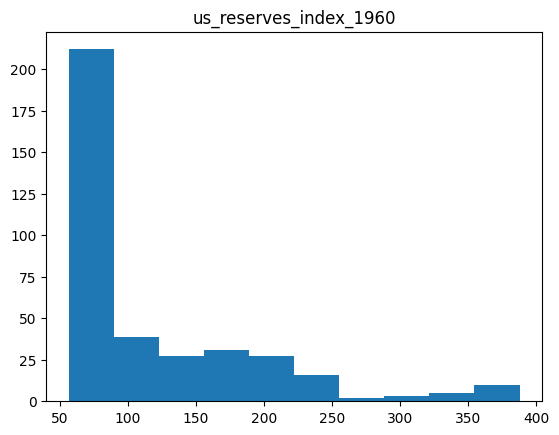

In [139]:
for item in df.columns[1:]:
    plt.figure()
    plt.hist(df[item])
    plt.title(str(item))

In [134]:
# df.to_excel('test_data.xlsx', index=False, engine='openpyxl')

# **5.3.1**

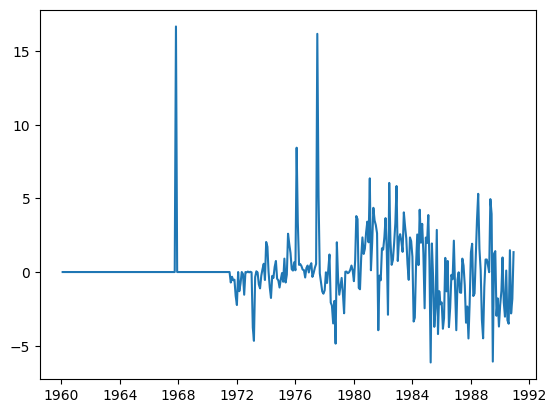

In [126]:
plt.plot(df['date'], df['spain_nominal_exchange_rate_growth'])

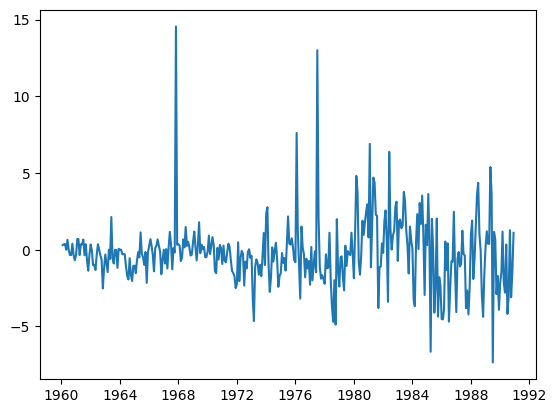

In [127]:
plt.plot(df['date'], df['spain_real_exchange_rate_growth'])

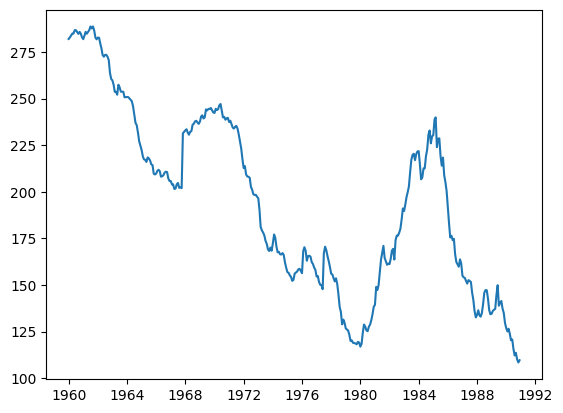

In [128]:
plt.plot(df['date'], df['spain_real_exchange_rate'])

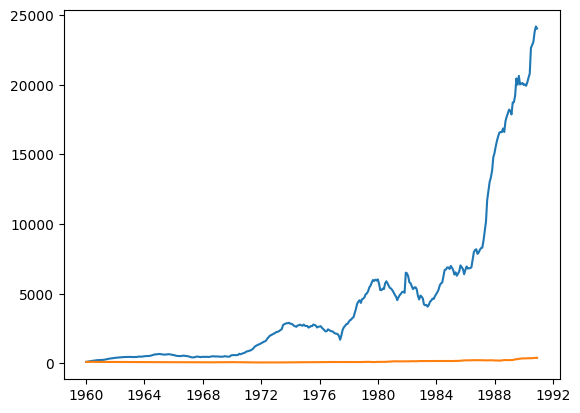

In [129]:
# Remember change to until 1973
plt.plot(df['date'], df['spain_reserves_index_1960'])
plt.plot(df['date'], df['us_reserves_index_1960'])

# **5.3.2**

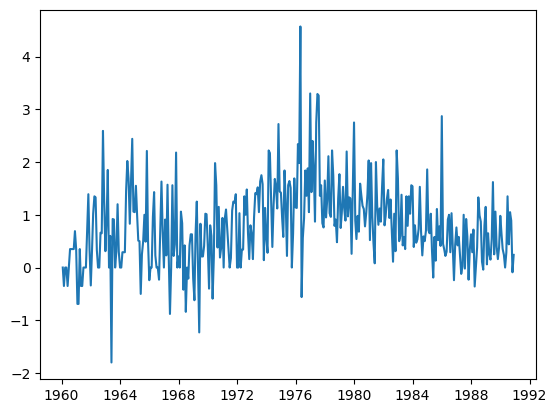

In [130]:
plt.plot(df['date'], df['spain_inflation_rate'])

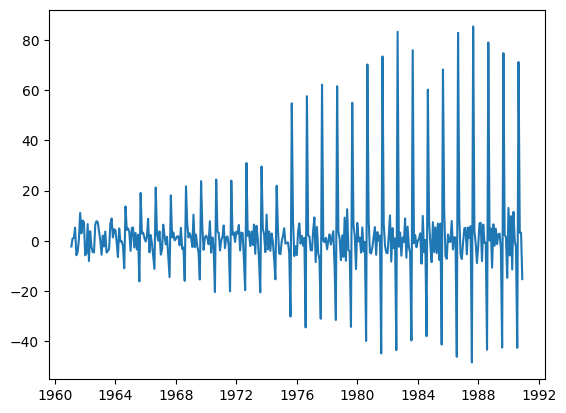

In [131]:
plt.plot(df['date'], df['spain_industrial_growth'])

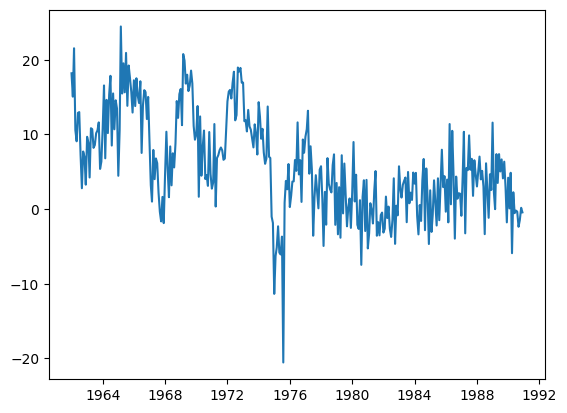

In [132]:
plt.plot(df['date'], df['spain_industrial_yearly_growth'])

# **5.3.3**